In [1]:
%matplotlib inline
from example import BFM
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams['image.cmap'] = 'cividis'


np.set_printoptions(precision=4)

# Parameters

In [2]:
# Grid sizes
n1 = 64 # x axis
n2 = 64 # y axis

# Maximum iterations for BFM
maxIters = 100

# Initial step size
sigma = 0.1

# Initialize mu and nu

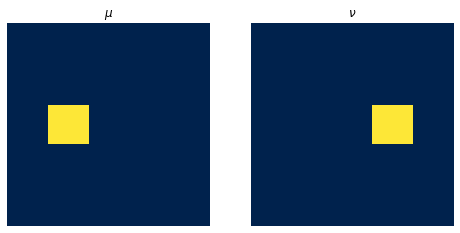

In [3]:
mu = np.zeros((n2,n1))
nu = np.zeros((n2,n1))

x,y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))

mu[(np.abs(x-0.3) < 0.1) & (np.abs(y-0.5) < 0.1)] = 1
nu[(np.abs(x-0.7) < 0.1) & (np.abs(y-0.5) < 0.1)] = 1

mu *= n1*n2 / np.sum(mu)
nu *= n1*n2 / np.sum(nu)

fig, ax = plt.subplots(1,2)
ax[0].imshow(mu)
ax[0].set_title("$\\mu$")
ax[0].axis("off")
ax[1].imshow(nu)
ax[1].set_title("$\\nu$")
ax[1].axis("off")
plt.show()

# Initialize phi and psi

In [4]:
phi = np.zeros((n2,n1))
psi = np.zeros((n2,n1))

phi = 0.5 * (x*x + y*y)
psi = 0.5 * (x*x + y*y)

# Run BFM

In [5]:
from scipy.fftpack import fft, dct, idct

# kernel for an inverse laplacian
xx, yy = np.meshgrid(np.linspace(0,np.pi,n1,False), np.linspace(0,np.pi,n2,False))
kernel = 2*n1*n1*(1-np.cos(xx)) + 2*n2*n2*(1-np.cos(yy))

# 2d DCT
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')
    
# 2d IDCT
def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

# one step of H1 gradient accent
def update_potential(phi, rho, nu, sigma, n1, n2):
    rho -= nu
    workspace = dct2(rho) / kernel
    workspace[0,0] = 0
    workspace = idct2(workspace)
    
    phi += sigma * workspace
    h1 = np.sum(workspace * rho) / (n1*n2)
    
    return phi, h1

def compute_w2(phi, psi, mu, nu, x, y):
    n1,n2 = mu.shape
    return np.sum(0.5 * (x*x+y*y) * (mu + nu) - nu*phi - mu*psi)/(n1*n2)

In [6]:
bfm = BFM(n1,n2,mu)

oldValue = compute_w2(phi, psi, mu, nu, x, y)

numDigitsIter=np.floor(np.log10(maxIters) + 1)

value = 0

rho = np.copy(mu)

gradSq = 1

for i in range(maxIters+1):
        
    bfm.get_rho(rho)
    phi, gradSq=update_potential(phi, rho, nu, sigma, n1, n2);

    bfm.convexify(phi, psi);

    value=compute_w2(phi, psi, mu, nu, x, y);
    sigma=bfm.step_update(sigma, value, oldValue, gradSq);

    oldValue=value;

    bfm.pushforward_op(phi, nu);

    bfm.get_rho(rho)
    psi, gradSq=update_potential(psi, rho, mu, sigma, n1, n2);

    bfm.convexify(psi, phi);

    bfm.pushforward_op(psi, mu);

    value=compute_w2(phi, psi, mu, nu, x, y);
    
    sigma=bfm.step_update(sigma, value, oldValue, gradSq);

    oldValue=value;

    sigma=np.maximum(sigma,.05);

    if i % 5 == 0:
        print(f'iter {i:5d}, W2 value: {value:4.4e}')

/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


iter     0, W2 value: 6.8813e-02
iter     5, W2 value: 7.6294e-02
iter    10, W2 value: 7.6294e-02
iter    15, W2 value: 7.6294e-02
iter    20, W2 value: 7.6294e-02
iter    25, W2 value: 7.6294e-02
iter    30, W2 value: 7.6294e-02
iter    35, W2 value: 7.6294e-02
iter    40, W2 value: 7.6294e-02
iter    45, W2 value: 7.6294e-02
iter    50, W2 value: 7.6294e-02
iter    55, W2 value: 7.6294e-02
iter    60, W2 value: 7.6294e-02
iter    65, W2 value: 7.6294e-02
iter    70, W2 value: 7.6294e-02
iter    75, W2 value: 7.6294e-02
iter    80, W2 value: 7.6294e-02
iter    85, W2 value: 7.6294e-02
iter    90, W2 value: 7.6294e-02
iter    95, W2 value: 7.6294e-02
iter   100, W2 value: 7.6294e-02


# Plotting result

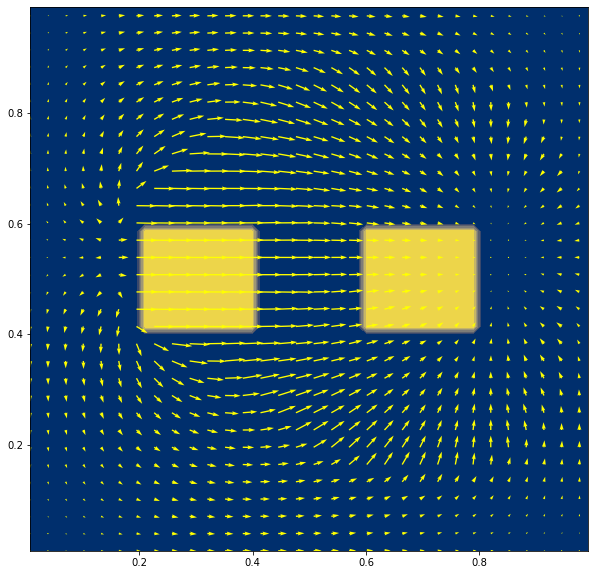

In [7]:

my, mx = np.gradient(psi - 0.5*(x*x+y*y))

s = 2
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.contourf(x,y,mu+nu)
ax.quiver(x[::s,::s], y[::s,::s], mx[::s,::s], my[::s,::s], color='yellow')


plt.show()